<a href="https://colab.research.google.com/github/bangilhan/kaggle/blob/master/%EC%A0%84%EC%A7%84_%ED%9B%84%EC%A7%84_%EB%8B%A8%EA%B3%84%EC%A0%81_%EB%B3%80%EC%88%98%EC%84%A0%ED%83%9D%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
 
df = pd.read_csv('./surgical_unit.csv') ## 데이터 불러오기


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


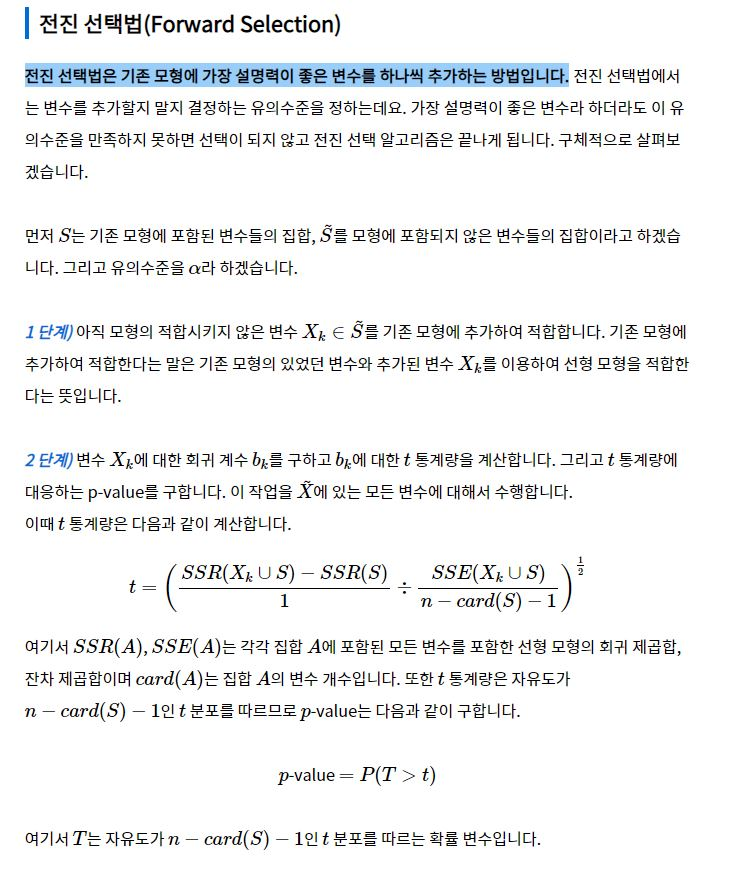

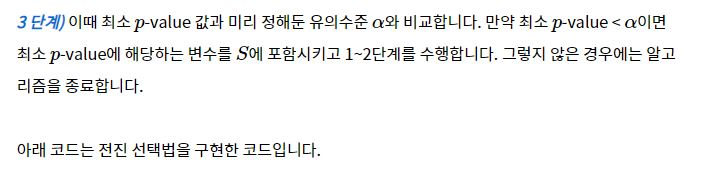

In [2]:
## 전진 선택법
variables = df.columns[:-2].tolist() ## 설명 변수 리스트
 
y = df['Survival_Time'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [3]:
selected_variables

['Liver_Test',
 'Alc_Heavy',
 'Enzyme_Test',
 'Prognostic_Index',
 'Blood_Clotting_Score']

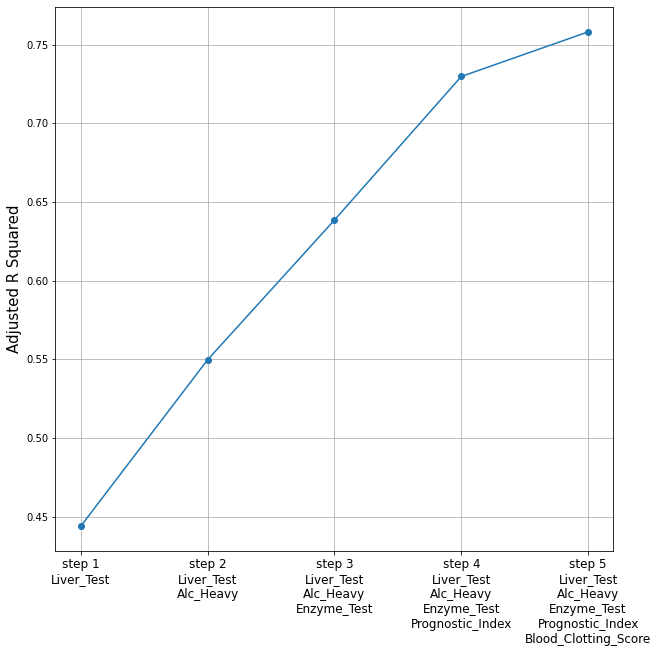

In [4]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [5]:
## 후진 소거법
variables = df.columns[:-2].tolist() ## 설명 변수 리스트
 
y = df['Survival_Time'] ## 반응 변수
selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(df[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

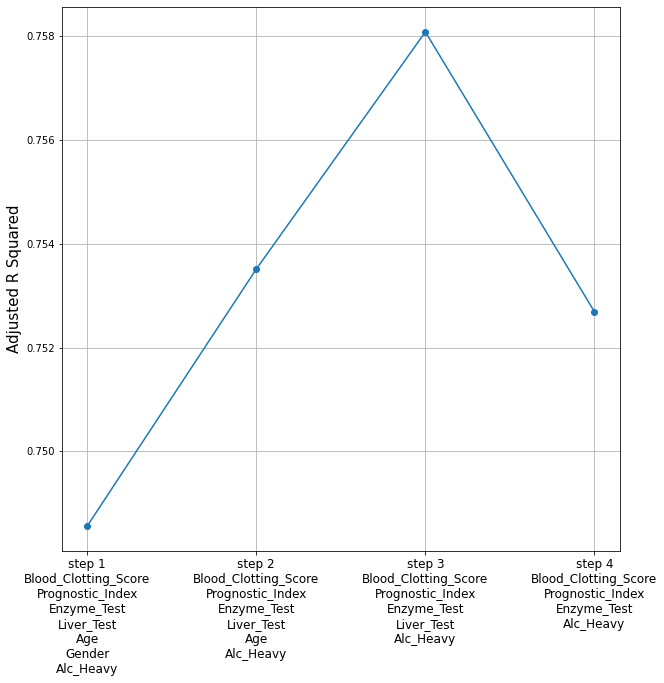

In [6]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [7]:
## 전진 단계별 선택법
variables = df.columns[:-2].tolist() ## 설명 변수 리스트
 
y = df['Survival_Time'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


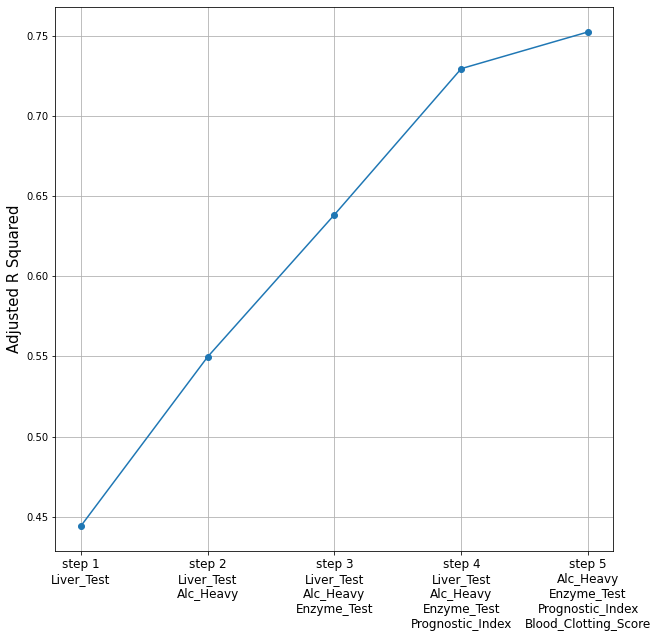

In [8]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

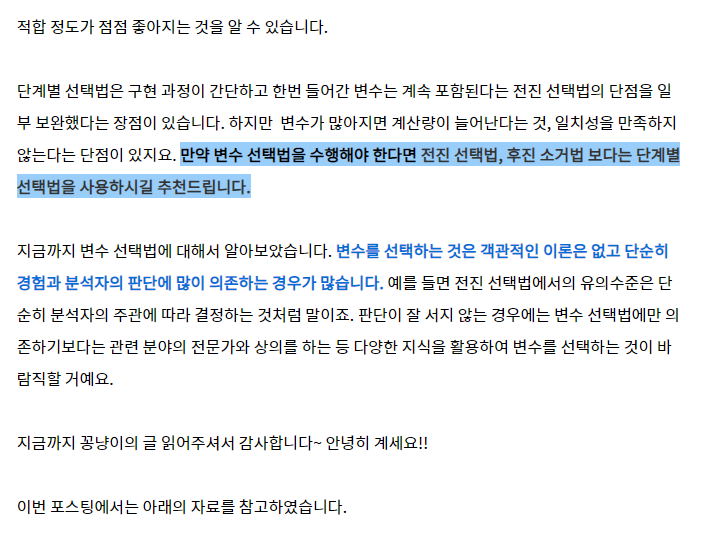